In [101]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [168]:
df = pd.read_csv('NGSIM Trajectories.csv')

In [169]:
df = df[df["Direction"] != 4]

In [170]:
df = df.drop(['Local_X', 'Local_Y', 'Global_X', 'Global_Y', 'Frame_ID', 'Tot_Frames', 'Veh_Len', 'Veh_Wid', 'Section', 'Direction', 'Veh_Class', 'Vehicle_Acc', 'Preceding_Veh', 'Following_Veh', 'Spacing', 'Headway'], axis=1)

In [184]:
idx = df.groupby("Vehicle_ID")['Epoch_ms'].transform(min) == df['Epoch_ms']
df_min_match = df[idx].reset_index(drop=True)
df_min_match = df_min_match.sort_values(by='Epoch_ms')

idx = df.groupby("Vehicle_ID")['Epoch_ms'].transform(max) == df['Epoch_ms']
df_max_match = df[idx].reset_index(drop=True)
df_max_match = df_max_match.sort_values(by='Epoch_ms')

df_col = df.groupby("Vehicle_ID").mean()['Veh_Velocity']
df_col = df_col.reset_index(drop=True)
df_min_match["Avg_Velocity"] = df_col

df_col = df.groupby("Vehicle_ID").max()['Veh_Velocity']
df_col = df_col.reset_index(drop=True)
df_min_match["Max_Velocity"] = df_col

In [186]:
df_final = df_min_match.copy()
df_final["Movement_Last"] = df_max_match["Movement"]
df_final["Intersection_Last"] = df_max_match["Intersection"]
df_final["Interarrival"] = df_min_match["Epoch_ms"].diff()
df_final["Leave_Time"] = df_max_match["Epoch_ms"]

In [187]:
df_final.head()

,Vehicle_ID,Epoch_ms,Veh_Velocity,Lane_ID,Org_Zone,Dest_Zone,Intersection,Movement,Avg_Velocity,Max_Velocity,Movement_Last,Intersection_Last,Interarrival,Leave_Time
0,2,1163033200,16.59,0,102,214,1,3,11.028804,51.32,1,5,NaN,1163201100
1,13,1163034600,20.01,0,102,203,1,3,17.780657,52.15,1,0,1400.0,1163092200
2,15,1163034800,17.29,1,101,214,0,1,11.986386,43.08,1,5,200.0,1163206000
3,17,1163036300,25.79,1,101,214,0,1,12.118666,46.42,1,5,1500.0,1163207900
4,21,1163039100,23.83,2,101,202,0,1,7.751914,23.83,1,0,2800.0,1163059900


In [188]:
# map origin zone to the nearest entrance intersection in the northbound direction
ent_0 = {101: 0}
ent_1 = dict.fromkeys([102, 123], 1)
ent_2 = dict.fromkeys([103, 122], 2)
ent_3 = dict.fromkeys([105, 106, 121], 3)
ent_4 = dict.fromkeys([108, 110, 111, 112, 119, 120], 4)
ent_5 = dict.fromkeys([113, 115, 116, 117, 118], 5)
intersection_entrances = {**ent_0, **ent_1, **ent_2, **ent_3, **ent_4, **ent_5}

df_final['Intersection'] = df_final['Org_Zone'].map(intersection_entrances)

# map destination zone to the nearest exit intersection in the northbound direction
exit_1 = dict.fromkeys([202, 223], 1)
exit_2 = dict.fromkeys([203, 222], 2)
exit_3 = dict.fromkeys([204, 205, 206, 221], 3)
exit_4 = dict.fromkeys([207, 208, 209, 210, 211, 220, 212], 4)
exit_5 = dict.fromkeys([213, 215, 216, 217, 218], 5)
exit_6 = {214: 6}
intersection_exits = {**exit_1, **exit_2, **exit_3, **exit_4, **exit_5, **exit_6}

df_final['Intersection_Last'] = df_final['Dest_Zone'].map(intersection_exits)

df_final.head()

,Vehicle_ID,Epoch_ms,Veh_Velocity,Lane_ID,Org_Zone,Dest_Zone,Intersection,Movement,Avg_Velocity,Max_Velocity,Movement_Last,Intersection_Last,Interarrival,Leave_Time
0,2,1163033200,16.59,0,102,214,1,3,11.028804,51.32,1,6,NaN,1163201100
1,13,1163034600,20.01,0,102,203,1,3,17.780657,52.15,1,2,1400.0,1163092200
2,15,1163034800,17.29,1,101,214,0,1,11.986386,43.08,1,6,200.0,1163206000
3,17,1163036300,25.79,1,101,214,0,1,12.118666,46.42,1,6,1500.0,1163207900
4,21,1163039100,23.83,2,101,202,0,1,7.751914,23.83,1,1,2800.0,1163059900


In [190]:
validation_set, model_set = np.array_split(df_final, 2)

model_set.to_csv("Processed_Vehicle_Data_Model.csv", index=False)
validation_set.to_csv("Processed_Vehicle_Data_Validation.csv", index=False)

# Input Analysis

In [159]:
# helper functions and common variables

l = len(model_set.index) # number of data cases
b = round(math.sqrt(l)) 

def autocorrelation_plot(data, points, x_n, s_n):
    p_k = []
    
    for k in range(1, points + 1):
        top = 0
        for j in range(0, len(data) - k):
            top += (data[j] - x_n) * (data[j + k] - x_n)
            
        bottom = (len(data) - k) * s_n
        p_k.append(top / bottom)
        
    plt.ylim(-1, 1)
    x = range(1, len(p_k) + 1)
    plt.scatter(x, p_k)
    
# compute x given two points and a y value
def interpolate(point1, point2, y):
    x_0 = point1[0]
    y_0 = point1[1]
    x_1 = point2[0]
    y_1 = point2[1]
    
    return x_0 + ((y - y_0) * (x_1 - x_0)) / (y_1 - y_0)

def compute_emp_dist(hist, y_i):
    f = [0]
    num_cases = sum(hist)
    
    for i in range(0, len(y_i) - 1):
        bin_val = hist[i] / num_cases
        f.append(bin_val + f[i])
    
    plt.scatter(y_i, f)
    return list(zip(y_i, f))

def compute_from_emp_dist(emp_dist):
    rand = random.uniform(0, 1)
    
    if rand == 0: return 0
    
    # find correct bin
    idx = 0
    while idx < len(emp_dist) and rand > emp_dist[idx][1]:
        idx += 1
    
    return round(interpolate(emp_dist[idx - 1], emp_dist[idx], rand))

## Interarrival Time

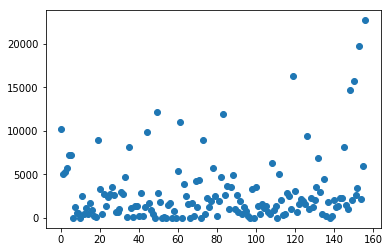

In [160]:
ia = model_set["Interarrival"].values

ia_mean = sum(ia) / len(ia)
ia_var = np.var(ia)

plt.scatter(list(range(0, len(ia))), ia)

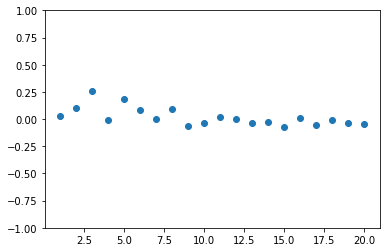

In [161]:
autocorrelation_plot(ia, 20, ia_mean, ia_var)

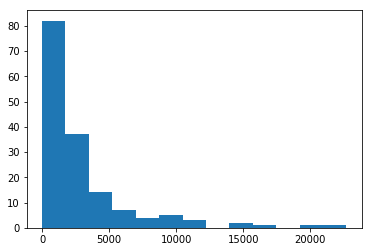

In [162]:
n, y_i, _ = plt.hist(ia, b)

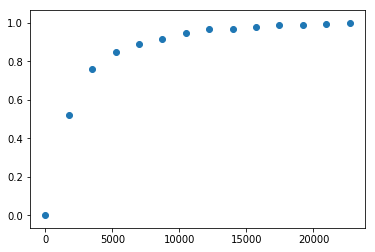

In [210]:
emp_dist = compute_emp_dist(n.tolist(), y_i)

In [211]:
# seems like an exponential distribution...
def compute_exponential_adequacy(obs_freq, class_intervals, mean, n):
    lmbda = 1 / mean

    ex_freq = [] # expected frequences E_i

    # (F(x_i+1) - F(x_i)) * num_samples
    for i in range(0, len(obs_freq)):
        term_1 = 1 - math.exp(-lmbda * class_intervals[i + 1])
        term_2 = 1 - math.exp(-lmbda * class_intervals[i])
        ex_freq.append((term_1 - term_2) * n)

    # combine e_i bins that are less than 5
    i = 0
    adequacy_measure = 0
    while i < len(ex_freq) - 1:
        j = i + 1
        while ex_freq[i] < 5 and j < len(ex_freq):
            ex_freq[i] += ex_freq[j]
            obs_freq[i] += obs_freq[j]
            j += 1
    
        ex_freq = ex_freq[:(i + 1)] + ex_freq[j:]
        obs_freq = obs_freq[:(i + 1)] + obs_freq[j:]
    
        adequacy_measure += ((obs_freq[i] - ex_freq[i]) ** 2) / (ex_freq[i])
    
        i += 1

    return adequacy_measure

a_m = compute_exponential_adequacy(n.tolist(), y_i, ia_mean, len(ia))
print(a_m)

11.642434262175323


## Intersection Entrance

0    56
1    34
2     5
3     3
4    24
5    35
Name: Intersection, dtype: int64


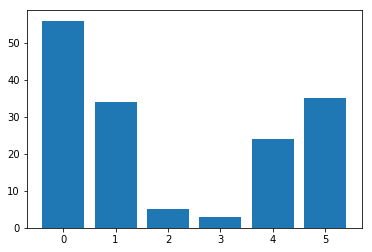

In [213]:
x = model_set["Intersection"].value_counts()
x = x.sort_index()
a = plt.bar(list(x.index), list(x.values))

print(x)

## Intersection Exit

1     25
2      7
3      2
4      4
5     16
6    103
Name: Intersection_Last, dtype: int64


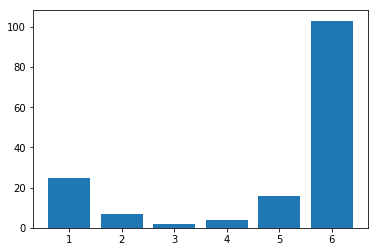

In [50]:
x = model_set["Intersection_Last"].value_counts()
x = x.sort_index()
print(x)
a = plt.bar(list(x.index), list(x.values))

## Vehicle Entrance Velocity

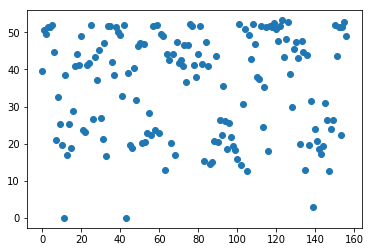

In [205]:
vel = model_set["Max_Velocity"].values

vel_mean = sum(vel) / len(vel)
vel_var = np.var(vel)

plt.scatter(list(range(0, len(vel))), vel)

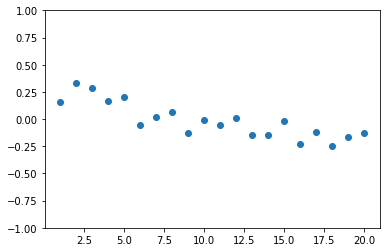

In [206]:
autocorrelation_plot(vel, 20, vel_mean, vel_var)

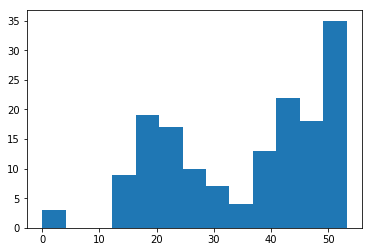

In [207]:
veh_n, veh_y_i, _ = plt.hist(vel, b)

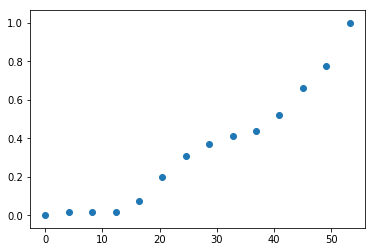

In [214]:
veh_emp_dist = compute_emp_dist(veh_n, veh_y_i)

In [155]:
# test to see if normal distribution
def normal_dist(x, mu, variance):
    first = math.exp(-((x - mu) ** 2) / (2 * variance))
    second = 1 / (math.sqrt(2 * math.pi * variance))
    
    return first * second

def compute_normal_adequacy(obs_freq, intervals, mean, variance, num):
    ex_freq = [] # expected frequences E_i

    # (F(x_i+1) - F(x_i)) * num_samples
    for i in range(0, len(obs_freq)):
        term_1 = normal_dist(intervals[i + 1], mean, variance)
        term_2 = normal_dist(intervals[i], mean, variance)
        ex_freq.append((term_1 - term_2) * num)
        
    # combine e_i bins that are less than 5
    i = 0
    adequacy_measure = 0
    while i < len(ex_freq) - 1:
        j = i + 1
        while ex_freq[i] < 5 and j < len(ex_freq):
            ex_freq[i] += ex_freq[j]
            obs_freq[i] += obs_freq[j]
            j += 1
    
        ex_freq = ex_freq[:(i + 1)] + ex_freq[j:]
        obs_freq = obs_freq[:(i + 1)] + obs_freq[j:]
    
        adequacy_measure += ((obs_freq[i] - ex_freq[i]) ** 2) / (ex_freq[i])
    
        i += 1
    
    return adequacy_measure
    
    
a_m = compute_normal_adequacy(vel_counts.tolist(), intervals, vel_mean, vel_var, len(vel))
print(a_m) # definitely not a normal distribution, need to make empirical distribution

-2085.628774878506


## Movement (likely won't pursue)

([<matplotlib.axis.XTick at 0x2861d766400>,
 <a list of 3 Text xticklabel objects>)

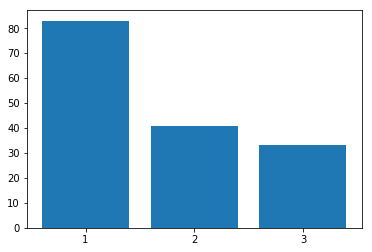

In [56]:
x = model_set["Movement"].value_counts()
x = x.sort_index()
a = plt.bar(list(x.index), list(x.values))
plt.xticks((1,2,3))